# SIR

## Setup

In [54]:
# data handling
import pandas as pd
import numpy as np

# visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.templates.default = "plotly_white"

# for compartmental models
import comod
from comod.models import sir  # Standard SIR model
from numpy.lib.stride_tricks import sliding_window_view

# model performance analysis
from utils import metrics, plot_acf_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sktime.performance_metrics.forecasting import geometric_mean_relative_absolute_error
import scipy.stats as st

# path handling
from pathlib import Path

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data

Read saved static data (csv file) of COVID-19 cases in Spain. More info in https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos. 

In [3]:
# name of the file
file_name = 'spanish-covid-19-data-renave-21Jun2022.csv'

# data path
base_dir = Path(os.getcwd()).parents[0]

# path to read final data
path_to_read_final_data = base_dir / 'data' / 'final-data' / file_name	

In [4]:
# read data and show the first samples
df = pd.read_csv(path_to_read_final_data, parse_dates=['Date'])
df.set_index(['Date'], inplace=True)
df.head()

,Population,Infected,Deaths,Recovered
Date,,,,
2020-01-07,46796540,0.0,0.0,0.0
2020-01-08,46796540,0.0,0.0,0.0
2020-01-09,46796540,0.0,0.0,0.0
2020-01-10,46796540,0.0,0.0,0.0
2020-01-11,46796540,0.0,0.0,0.0


In [5]:
df = df[df.index > pd.to_datetime('2020-02-20')]

## Prepare data 

Before further analysis, data must be prepared to fit the model implementation:
- Population is saved as constant in POPULATION variable. 
- Only variables needed for the analysis are kept: susceptible, infected and recovered cases. 
- Transform dates to integer timesteps to prevent unexpected errors when handling datetime types. 
- Transform data from DataFrame to arrays S, I, R to speed up computations. 

In [6]:
# constant population
POPULATION = df['Population'].mean()

df2 = df[['Infected', 'Deaths', 'Recovered']]

In [7]:
# Confirmed, Deaths, Recovered and Active cases to SIR form
def CDRA_to_SIR(df, population):
    df2 = df[[]].copy()
    df2["S"] = 0  # Just to produce the desired order
    df2["I"] = df[["Infected"]]
    df2["R"] = df["Deaths"] + df["Recovered"]
    df2["S"] = population - df2["I"] - df2["R"]
    return df2

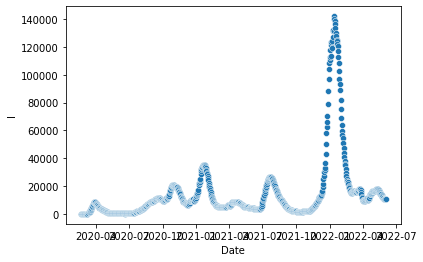

In [8]:
df3 = CDRA_to_SIR(df2, POPULATION)

# plot all avaible data of infected cases
sns.scatterplot(df3.index, df3['I'])
plt.show()

# # or plot a subset 
# sns.scatterplot(df3.index[50:200], df3['I'][50:200])
# plt.show()

In [9]:
# use day count instead of datetime
t = np.linspace(0, len(df3)-1, len(df3))

# S, I, R to array
S = df3['S'].values
I = df3['I'].values
R = df3['R'].values

# SIR modeling

To fit the SIR model, the package comod is used (doc: https://comod.readthedocs.io/en/latest/). 

It is not adequate to fit a single SIR model to all available data: SIR model is deterministic, so given an initial state, the solution is uniquely determined by it. Therefore, small time windows need to be considered to fit a SIR model on each: the initial values of S, I, R in each window will determine the predictions.

For easy of analysis, the class WindowFit is defined. Given all data, the class generates the necessary windows, plots and evaluates the predictions. Two forms of evaluations are allowed: multiple train-test splits and walk-forward validation (recomended). This should be specified by the eval_mode parameter, which is 'WF' by default. The metrics considered to evaluate performance are defined in the variable metrics. 

For sake of comparison, a baseline or benchmark to beat has been defined. The baseline is taken by predicting for time t+1 the value of t, i.e., repeating the last value.

## Metrics

In [11]:
class WindowFit:
    
    def __init__(self, window_size, steps_ahead, data, metrics=metrics, eval_mode='WF'):
        # parameters
        self.window_size = window_size
        self.steps_ahead = steps_ahead

        # store raw data
        self.data = np.array(data)
        self.train, self.test = self.train_test_split(self.data, eval_mode)
        self.baseline = self.get_baseline(self.train)

        # metrics to evaluate
        self.metrics = metrics


    def train_test_split(self, data, eval_mode):
        """
        Split data into train and test subsets
        Args:
            data (pd.DataFrame or np.array): Data to be split
            eval_mode (str): Mode of evaluation, 'WF' for Walk Forward evaluation, 'MTTS' for Multiple Train Test Splits 
        Returns:
            train (numpy.ndarray): Train data
            test (numpy.ndarray): Test data
        """
        train, test = [], []

        if eval_mode == 'WF':
            # walk forward evaluation
            for compartiment in data:
                train.append(sliding_window_view(compartiment[:-(self.steps_ahead)], window_shape=self.window_size))
                test.append(np.array([np.array(compartiment[i:i+self.steps_ahead]) for i in range(self.window_size, len(compartiment)) if len(np.array(compartiment[i:i+self.steps_ahead]))==self.steps_ahead]))

        elif eval_mode == 'MTTS':
            n_windows = data.shape[1]//(self.window_size+self.steps_ahead) # perfect windows 
            data_start_point = data.shape[1]%(self.window_size+self.steps_ahead) # data start to generate perfect windows sizes
            
            for compartiment in data:
                window = np.array(np.split(compartiment[data_start_point:], n_windows))
                train.append(window[:, :-self.steps_ahead])
                test.append(window[:, -self.steps_ahead:])
        else:
            raise ValueError('Evaluation mode not recognized')

        return np.array(train), np.array(test)

    def get_baseline(self, train):
        baselines = []
        for compartiment in train:
            baseline = []
            for window in compartiment:
                baseline.append(np.repeat(window[-1], self.steps_ahead))           
            baselines.append(np.array(baseline))
        return np.array(baselines)

    def fit_predict(self, window, return_only_predictions=False):
        """
        Fit the model to a window and predict the future

        Args:
            window (numpy.ndarray): a window with [S, I, R] data to fit SIR model and predict future

        Returns:
            predictions (numpy.ndarray): a window with [S, I, R] data predicted from the fitted SIR model

        """
        # define a SIR model
        model = comod.Model(
            ["S", "I", "R"],  # States
            ["beta", "gamma"],  # Coefficients
            [  # Rules in the form (origin, destination, coefficient)
                ("S", "I", "beta I / N"),  # N is a special state with the total population
                ("I", "R", "gamma"),
            ],
            # Special state names can be set with the following options:
            # Total population. Can be used in the coefficients, but not as origin/destination.
            sum_state="N", 
            # The nothingness (?) from which one is born and to which one dies.
            nihil_state="!",  # Can be used as origin/destination, but not in the cofficients.
        )
        
        # define time mesh
        t_window = np.arange(self.window_size) # time mesh for the window with step_size>window_size
        
        # best-fit model
        fit_pars = model.best_fit(
            np.asarray(window), t_window, [0.2, 0.2]  # Existing data  # Time mesh  # Initial guess
        ).x

        # get fitted parameters
        fit_beta, fit_gamma = fit_pars

        # initial states:
        S0, I0, R0 = window[0][0], window[1][0], window[2][0]

        # solve the model numerically
        S_simulated, I_simulated, R_simulated = model.solve(
            (S0, I0, R0),  # Initial state
            [fit_beta, fit_gamma],  # Coefficient values
            t=np.arange(self.window_size+self.steps_ahead),  # Time mesh
            method="RK45",  # see scipy.integrate.solve_ivp
        )

        if return_only_predictions is True:
            return S_simulated[-self.steps_ahead:], I_simulated[-self.steps_ahead:], R_simulated[-self.steps_ahead:]
        else:
            return S_simulated, I_simulated, R_simulated
        
    def random_windows(self, return_baseline=False):
        """
        Generate random windows
        """
        random_index = np.random.randint(0, self.train.shape[1])
        random_window_train, random_window_test = self.train[:, random_index], self.test[:, random_index]
        if return_baseline is True:
            random_window_baseline = self.baseline[:, random_index]
            return random_window_train, random_window_test, random_window_baseline[1]
        else:
            return random_window_train, random_window_test

    def plot_windows(self, max_subplots=3):
        """
        Plot real infected data, the predictions and the baseline to compare
        Args:
            max_subplots (int): maximum number of subplots to plot
        """
        example_windows = [self.random_windows(return_baseline=True) for _ in range(max_subplots)]

        for train_window, test_window, baseline_window in example_windows:
            t_window = np.arange(self.window_size+self.steps_ahead)

            _, I_simulated, _ = self.fit_predict(train_window, return_only_predictions=False)

            plt.figure(figsize=(8, 5))
            plt.scatter(t_window[:self.window_size], train_window[1], color='dodgerblue', label='I real')
            plt.plot(t_window, I_simulated, color='orange', label='I simulated')
            plt.scatter(t_window[-self.steps_ahead:], I_simulated[-self.steps_ahead:], color='darkorange', label='I predicted')
            plt.scatter(t_window[-self.steps_ahead:], test_window[1], color='blue', label='I test')
            plt.plot(t_window[-self.steps_ahead:], baseline_window,  marker='o', color='silver', label='I baseline')

            plt.ylabel('Infected')
            plt.xlabel('Time steps')
            plt.legend()
            plt.show()

    def get_all_predictions(self, horizon):
        """
        Get all predictions in a single array for a time horizon of 'horizon'

        Args:
            horizon (int): time horizon to predict
        """
        predictions = []
        for i in range(self.train.shape[1]):
            window = self.train[:, i]
            _, I_pred, _ = self.fit_predict(window, return_only_predictions=True)
            predictions.append(I_pred[(horizon-1)])
        return np.array(predictions)

    def get_residuals(self, horizon):
        """
        Get the residuals (residuals = expected_value-forecast_value) for a time horizon of 'horizon'
        """
        I_pred_total = self.get_all_predictions(horizon)
        I_true = self.test[1][:, horizon-1]
        return I_true - I_pred_total # forecast errors

    def evaluate(self):
        """
        Evaluate the performance of the model
        """
        evaluation = {}

        # evaluate per timesteps
        for i in range(self.steps_ahead):
            sir_step_evaluation, baseline_step_evaluation = {}, {}

            test_step = self.test[1][:, i]
            predicted_step = self.get_all_predictions(horizon=i+1)
            baseline_step = self.baseline[1][:, i]

            # evaluate
            for metric_name, metric in self.metrics.items():
                try:
                    sir_step_evaluation[metric_name] = metric(test_step, predicted_step)
                    baseline_step_evaluation[metric_name] = metric(test_step, baseline_step)
                except:
                    sir_step_evaluation[metric_name] = np.nan
                    baseline_step_evaluation[metric_name] = np.nan

                sir_step_evaluation['GMRAE'] = geometric_mean_relative_absolute_error(test_step, predicted_step, y_pred_benchmark=baseline_step)
                evaluation[f'step_{i+1}'] = sir_step_evaluation
                evaluation[f'baseline_step_{i+1}'] = baseline_step_evaluation

        return evaluation
        
        

## Fit

An example of how to use the previous class to adjust a model to successive windows of size window_size=7 (7 time steps) to predict the next steps_ahead=3 (3 time steps) is shown below. That is, predict the infected cases for the next 3 days knowing the infected cases values of the previous 7 days. 

In [12]:
# create an object of the class
w = WindowFit(window_size=7, steps_ahead=3, data=[S, I, R], eval_mode='WF')
# get a random train and test window
window_train, window_test = w.random_windows()
# fit the model and get the predictions
S_simulated, I_simulated, R_simulated = w.fit_predict(window_train, return_only_predictions=True)


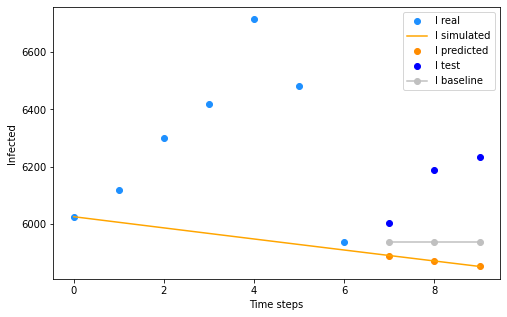

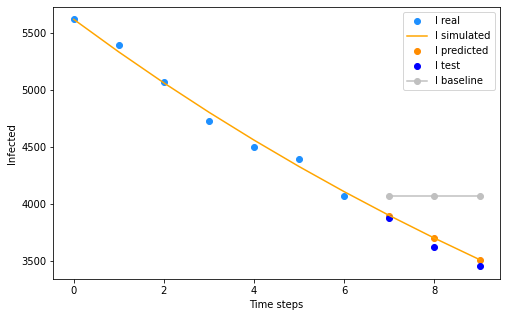

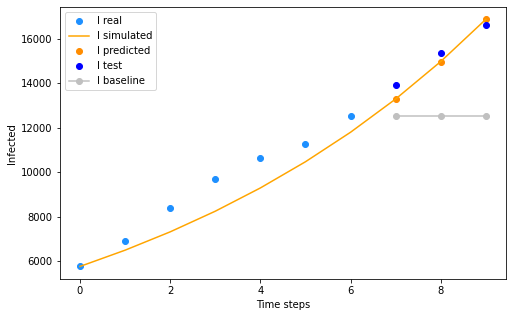

In [13]:
# fit model and plot the results for 3 random windows
w.plot_windows(max_subplots=3)

# Evaluation

To evaluate the performance of the model (and to compare it later with other types of models), data is divided into train and test sets. 

In [29]:
test_size = int(0.3*len(df))
train_data = [S[:test_size], I[:test_size], R[:test_size]]
test_data = [S[-test_size:], I[-test_size:], R[-test_size:]]

In [28]:
# evaluate the model
w_e = WindowFit(window_size=20, steps_ahead=14, data=test_data, eval_mode='WF')
e = w_e.evaluate()
# show the evaluation as DataFrame
pd.DataFrame(e).style.highlight_min(axis=1)

,step_1,baseline_step_1,step_2,baseline_step_2,step_3,baseline_step_3,step_4,baseline_step_4,step_5,baseline_step_5,step_6,baseline_step_6,step_7,baseline_step_7,step_8,baseline_step_8,step_9,baseline_step_9,step_10,baseline_step_10,step_11,baseline_step_11,step_12,baseline_step_12,step_13,baseline_step_13,step_14,baseline_step_14
RMSLE,0.164544,0.056256,0.179081,0.106092,0.198966,0.154140,0.221847,0.200838,0.247479,0.246602,0.276569,0.291887,0.309930,0.336961,0.345353,0.381071,0.383111,0.424703,0.421611,0.467716,0.460845,0.510136,0.500912,0.551999,0.542099,0.593348,0.584256,0.634216
GMRAE,2.259333,nan,1.444699,nan,1.147061,nan,1.167162,nan,1.065833,nan,1.066607,nan,0.958649,nan,1.045503,nan,1.053026,nan,1.106561,nan,1.101618,nan,1.127562,nan,1.167865,nan,1.145429,nan
MAE,5214.531570,1480.142857,5626.633279,2828.165899,6248.330435,4094.027650,7086.482427,5313.866359,8086.395097,6561.857143,9184.736179,7779.958525,10527.729997,9003.714286,12273.774451,10215.981567,14165.463126,11417.133641,16334.780819,12596.566820,18702.790770,13773.433180,21303.795168,14925.405530,24184.558190,16061.119816,27446.183048,17200.944700
RMSE,11723.559124,2585.119863,12506.895246,4760.105581,13667.621230,6864.268144,15146.503795,8933.109304,17071.108145,10965.309805,19656.533333,12998.013451,23112.459866,15034.102729,27327.248157,17004.214598,32239.159156,18948.549537,37762.559361,20853.771438,43958.705383,22727.794802,51007.407898,24577.070420,59110.135393,26400.818155,68210.702153,28196.079603
MAPE,0.118813,0.043552,0.135478,0.082653,0.155890,0.120091,0.178483,0.155289,0.202018,0.190445,0.227451,0.224723,0.257079,0.259413,0.292642,0.293940,0.330733,0.328314,0.370708,0.362778,0.411872,0.397348,0.455102,0.431505,0.501415,0.465113,0.552026,0.499546


It should be noted that the lower the error, the better the forecast. In this analysis the point of interest is the 14-day forecast. #TODO: ampliar a estudio a largo plazo también.

## Trial-error best window size

The code below evaluates the results for different window sizes and the table highlights the best ones (lower ones). 

In [30]:
eval_window_size = {}

for window_size in range(2, 60):
    print(f'Evaluating SIR for window size {window_size}...')
    w = WindowFit(window_size, 14, data=train_data, eval_mode='WF')
    evaluation_metrics = w.evaluate()
    
    window_error = evaluation_metrics['step_14']

    eval_window_size[f'window_size_{window_size}'] = window_error

Evaluating SIR for window size 2...
Evaluating SIR for window size 3...
Evaluating SIR for window size 4...
Evaluating SIR for window size 5...
Evaluating SIR for window size 6...
Evaluating SIR for window size 7...
Evaluating SIR for window size 8...
Evaluating SIR for window size 9...
Evaluating SIR for window size 10...
Evaluating SIR for window size 11...
Evaluating SIR for window size 12...
Evaluating SIR for window size 13...
Evaluating SIR for window size 14...
Evaluating SIR for window size 15...
Evaluating SIR for window size 16...
Evaluating SIR for window size 17...
Evaluating SIR for window size 18...
Evaluating SIR for window size 19...
Evaluating SIR for window size 20...
Evaluating SIR for window size 21...
Evaluating SIR for window size 22...
Evaluating SIR for window size 23...
Evaluating SIR for window size 24...
Evaluating SIR for window size 25...
Evaluating SIR for window size 26...
Evaluating SIR for window size 27...
Evaluating SIR for window size 28...
Evaluatin

In [31]:
# show the evaluations highlighting the best metrics
pd.DataFrame(eval_window_size).style.highlight_min(axis=1)

,window_size_2,window_size_3,window_size_4,window_size_5,window_size_6,window_size_7,window_size_8,window_size_9,window_size_10,window_size_11,window_size_12,window_size_13,window_size_14,window_size_15,window_size_16,window_size_17,window_size_18,window_size_19,window_size_20,window_size_21,window_size_22,window_size_23,window_size_24,window_size_25,window_size_26,window_size_27,window_size_28,window_size_29,window_size_30,window_size_31,window_size_32,window_size_33,window_size_34,window_size_35,window_size_36,window_size_37,window_size_38,window_size_39,window_size_40,window_size_41,window_size_42,window_size_43,window_size_44,window_size_45,window_size_46,window_size_47,window_size_48,window_size_49,window_size_50,window_size_51,window_size_52,window_size_53,window_size_54,window_size_55,window_size_56,window_size_57,window_size_58,window_size_59
RMSLE,1.363128,1.315196,1.278774,1.275534,1.308871,1.335131,1.341705,1.350732,1.364475,1.372428,1.374683,1.378951,1.379970,1.373624,1.351643,1.327945,1.312042,1.308367,1.315437,1.322588,1.330979,1.341939,1.354980,1.372388,1.394562,1.418435,1.441334,1.469058,1.501129,1.538145,1.576948,1.614901,1.650581,1.681713,1.709790,1.733379,1.751124,1.763796,1.774645,1.783266,1.790830,1.796439,1.800140,1.802891,1.804529,1.804963,1.805621,1.806523,1.807638,1.809660,1.812037,1.814857,1.818770,1.824218,1.832134,1.842018,1.855400,1.870968
GMRAE,0.925637,0.866329,0.830991,0.798432,0.798106,0.809107,0.783823,0.739606,0.748043,0.773575,0.764522,0.734875,0.750700,0.797422,0.779856,0.775173,0.748768,0.703452,0.692245,0.649791,0.649909,0.641338,0.695129,0.702519,0.739670,0.802995,0.850704,0.820100,0.886874,0.897183,0.891866,0.881638,0.872068,0.903852,0.943003,0.959866,0.963488,0.991156,0.994201,0.947645,0.977583,1.065599,1.145010,1.227041,1.278380,1.327145,1.370277,1.447841,1.441629,1.501860,1.553112,1.612425,1.682434,1.760116,1.806551,1.917637,1.981044,2.204400
MAE,22967.089105,14903.031662,11132.068192,10708.298201,11279.928935,11749.155403,11928.980405,12043.491727,11962.706009,11713.298303,11381.493072,11092.925833,10206.630492,8612.844017,6263.973094,4091.213940,2673.375566,2044.405835,1863.903725,1750.083980,1725.642270,1763.029840,1836.873031,1895.753785,1939.571839,1968.877209,1991.876516,2009.012108,2024.455168,2034.399365,2038.324931,2042.695986,2050.451668,2068.945958,2088.973776,2102.493414,2117.111436,2138.172982,2159.977827,2195.952916,2259.995877,2346.099044,2436.110004,2538.248807,2640.398505,2742.455276,2848.558610,2961.775045,3074.268505,3203.668888,3339.987942,3486.472960,3637.386905,3799.195364,3964.927412,4147.982648,4339.287087,4552.079079
RMSE,175044.708279,78983.230919,42792.071514,41387.800044,44212.700848,47143.074218,49849.471808,52857.837170,54761.630102,55167.938590,56192.278462,58082.071482,54976.574857,44603.900316,30555.873184,17456.391622,7106.672070,3335.383561,3024.718405,2867.713903,2840.576981,2877.447943,2931.028574,2988.899988,3034.719503,3069.755465,3109.337618,3151.979735,3196.939379,3256.606765,3325.572904,3407.425320,3513.775401,3634.743670,3776.438967,3935.413030,4106.378800,4291.380821,4493.771303,4709.466682,4933.740148,5160.429795,5378.391041,5589.048614,5792.729910,5991.419833,6188.527212,6385.452831,6585.173052,6789.893982,6992.630590,7190.777508,7388.650614,7572.470852,7746.785902,7926.308234,8122.480384,8333.732877
MAPE,23.604992,7.947031,2.803413,1.932294,1.980187,2.006761,1.928050,1.894573,1.856003,1.795446,1.724092,1.671692,1.533540,1.306568,0.980362,0.691571,0.509494,0.428717,0.403783,0.390056,0.395699,0.412230,0.437459,0.461093,0.482574,0.503437,0.523943,0.542803,0.562249,0.580681,0.598128,0.615073,0.632384,0.650224,0.668697,0.686315,0.704223,0.723534,0.742600,0.762505,0.784695,0.808602,0.832547,0.857117,0.880543,0.904003,0.927139,0.950385,0.972392,0.995764,1.019384,1.044051,1.068581,1.093200,1.118864,1.146818,1.176270,1.208865


Show the evolution of each metric as the size of each window increases.

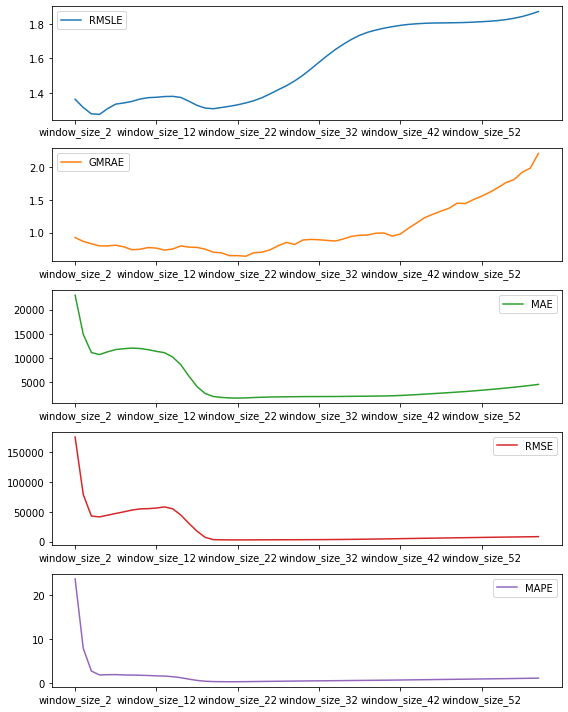

In [33]:
# metric evolution subplots
fig, ax = plt.subplots(5, figsize=(8, 10), tight_layout=True)
pd.DataFrame(eval_window_size).T.plot(ax=ax, subplots=True)
plt.show()

In conclusion:
- RMSLE increases drastically from window size 22 onwards. The MAE, RMSE and MAPE reach a minimum above window size 22 and do not vary much after that point.
- The one with the best overall results is window of size 22. 

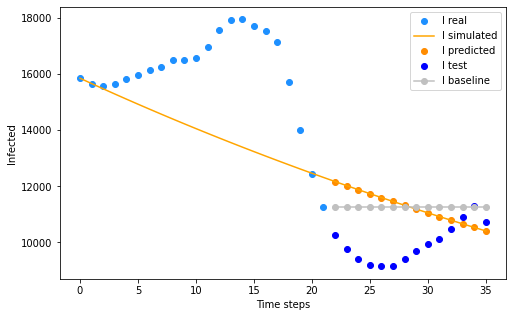

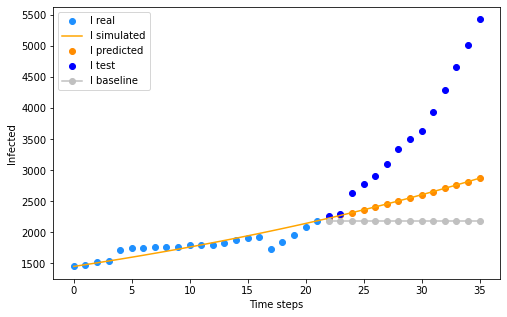

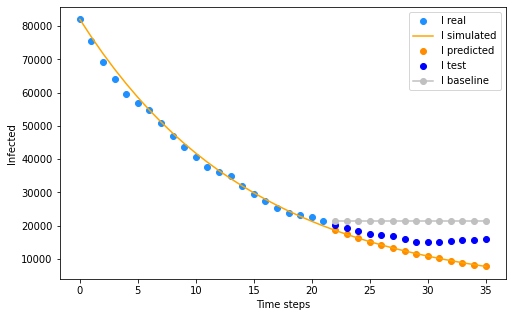

In [45]:
# create an object of the class
w_22_14 = WindowFit(window_size=22, steps_ahead=14, data=test_data, eval_mode='WF')
# get a random train and test window
window_train, window_test = w_22_14.random_windows()
# fit the model and get the predictions
S_simulated, I_simulated, R_simulated = w_22_14.fit_predict(window_train, return_only_predictions=True)
# fit model and plot the results for 3 random windows
w_22_14.plot_windows(max_subplots=3)

# Residuals exploration

If the model has succeeded in capturing all the information and structure of the available data, then the residuals should be random. That is, residuals are the part left that cannot be predicted. The exploration of these residuals provides a better understanding of the model and its scope. If the study suggests that the residuals are not random, i.e., that they follow some pattern or structure, then the model can be improved. 

The residual errors for a time step ahead (t+14) are obtained below:

In [34]:
w = WindowFit(window_size=22, steps_ahead=14, data=[S, I, R], eval_mode='WF')	
residuals = w.get_residuals(horizon=14) # residuals for the first time step (t+14)

First, errors are ploted over time. If the model was perfect, the resulting plot should be iid noise, showing the residuals distributed around zero (zero mean) with no pattern (trend, seasonal components, etc.). Then, the distribution of errors is studied via hisotograms and density plots.

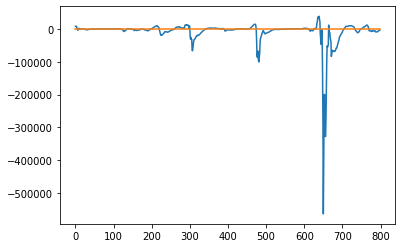

In [35]:
# line plot of the residuals
plt.plot(residuals)
plt.plot(np.zeros(residuals.shape))

Most residuals seem to be near to zero, although there are some extremely large errors. These values will cause the mean of the residuals to be a high negative number. In addition, these negative values mean that the model underpredicts: there are many more infected cases than expected by the model.

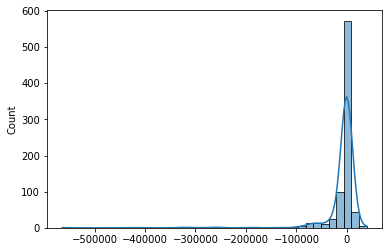

In [49]:
# histogram and density plot
sns.histplot(residuals, kde=True, bins=40)
plt.show()

Histogram and density plot of residuals showing heavy tail to the left representing the large errors mentioned before.

The code below evaluate which distribution fits better to the data and returns its parameters.

In [37]:
# def get_best_distribution(data):
#     dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
#     dist_results = []
#     params = {}
#     for dist_name in dist_names:
#         dist = getattr(st, dist_name)
#         param = dist.fit(data)

#         params[dist_name] = param
#         # Applying the Kolmogorov-Smirnov test
#         D, p = st.kstest(data, dist_name, args=param)
#         # print("p value for "+dist_name+" = "+str(p))
#         dist_results.append((dist_name, p))

#     # select the best fitted distribution
#     best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
#     # store the name of the best fit and its p value

#     print("Best fitting distribution: "+str(best_dist))
#     print("Best p value: "+ str(best_p))
#     print("Parameters for the best fit: "+ str(params[best_dist]))

#     return best_dist, best_p, params[best_dist]

# get_best_distribution(residuals)

Some statistics are now calculated to provide information on how the values are distributed around zero. If the model was perfect, then the mean would be zero; a negative mean represents a negative bias in the forecasts; a positive mean represents a positive bias.

In [38]:
from scipy.stats import kurtosis, skew

residuals_stats = pd.DataFrame(residuals).describe().T
residuals_stats['kurtosis'] = kurtosis(residuals) # excess kurtosis of normal distribution (if normal, kurtosis is zero)
residuals_stats['skewness'] = skew(residuals) # skewness of normal distribution (if normal, skewness is zero)
residuals_stats.T

,0
count,799.000000
mean,-8475.494554
std,39874.472341
min,-563858.156980
25%,-5061.884745
50%,-143.888755
75%,1170.916520
max,39153.093210
kurtosis,80.155308
skewness,-7.942315


- The mean is highly far from zero and negative (not even close to zero)
- Skewness is highly negative, i.e, the distribution of residuals exceeds that value from the overall shape of a normal distribution.
- Kurtosis is highly positive, i.e, the shape of the tails of the distribution of residuals exceeds that value from the shape of the tails of the normal distribution. The tails of this distribution are thicker than the normal dist.

Now the Q-Q plot is studied.

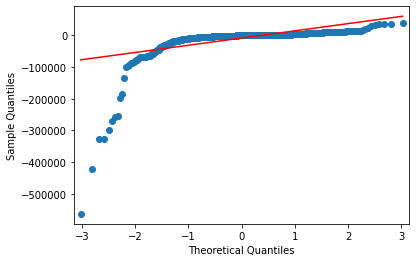

In [55]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='r')
plt.show()

The Q-Q plot confirms that residuals distribution is normal too peaked in zero, with heavy tails (left end of the Q-Q plot deviate from the diagonal) in comparison with a normal distribution. The distribution is more dispersed (higher std) than a normal distribution.

The autocorrelation plot shows the relation between a observation with prior observations in time. Ideally the residuals should not be correlated (scores between the dashed and dotes lines in the plot).

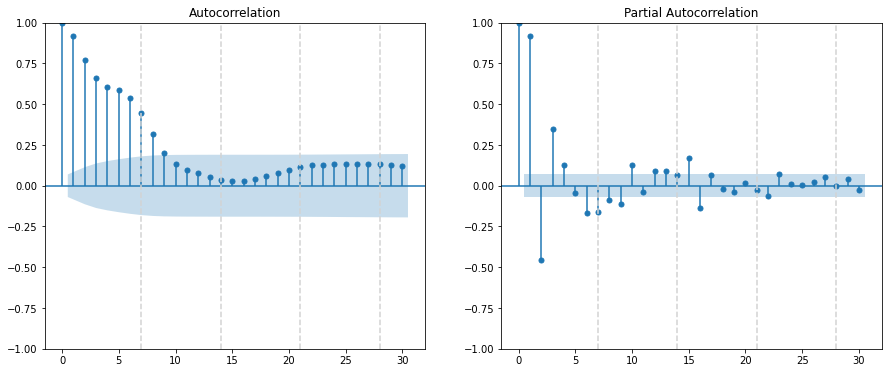

In [56]:
from pandas.plotting import autocorrelation_plot

plot_acf_pacf(residuals)
plt.show()

Since there exist significant autocorrelations in the plot, the model is missing information. The relationship between observations and lagged observations must be included in a model. 

Uncomment code below to study the residuals for different window sizes.

In [42]:
# def plot_residuals():
#     for window_size in range(2, 14):
#         print(f'Evaluating SIR for window size {window_size}...')
#         w = WindowFit(window_size, 1, data=[S, I, R], eval_mode='WF')
#         residuals = w.get_residuals(horizon=1)
#         #line plot
#         plt.plot(residuals)
#         plt.plot(np.zeros(residuals.shape))
#         plt.show()
#         # histogram and density plot
#         sns.histplot(residuals, kde=True, bins=40)
#         plt.show()
#         # qqplot
#         qqplot(residuals, line='r')
#         plt.show()
#         # autocorrelation plot
#         autocorrelation_plot(residuals)
#         plt.show()
#         # summary stats
#         residuals_stats = pd.DataFrame(residuals).describe().T
#         residuals_stats['kurtosis'] = kurtosis(residuals) # excess kurtosis of normal distribution (if normal, kurtosis is zero)
#         residuals_stats['skewness'] = skew(residuals) # skewness of normal distribution (if normal, skewness is zero)
#         display(residuals_stats.T)

# plot_residuals()

# Conclusion:
- The residuals obtained with this model are not random, indicating that SIR model has failed in explaining the behaviuor of the system. 